# Warm Up: Predict blood donations
(C) 2018 Dariusz Kajtoch

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. Data Exploration

In [4]:
data = pd.read_csv('./predict_blood_donations.csv')
print(data.columns)
data.columns = ['Id', 'MonthLast', 'Num', 'Vol', 'MonthFirst', 'Predict']
data.head()

Index(['Unnamed: 0', 'Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation',
       'Made Donation in March 2007'],
      dtype='object')


,Id,MonthLast,Num,Vol,MonthFirst,Predict
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [17]:
# check for nulls and distinct values
nulls = data.isnull().sum()
distinct = data.nunique()

print(pd.DataFrame({'NoNulls': nulls.iloc[:], 'NoDistinct': distinct.iloc[:]}))

            NoDistinct  NoNulls
Id                 576        0
MonthLast           29        0
Num                 29        0
Vol                 29        0
MonthFirst          75        0
Predict              2        0


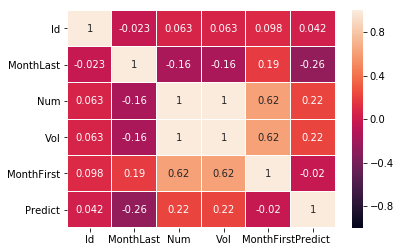

In [24]:
sns.heatmap(data.corr(),
            vmin=-1.,
            vmax=1.,
            annot=True,
            linewidths=.05
           )

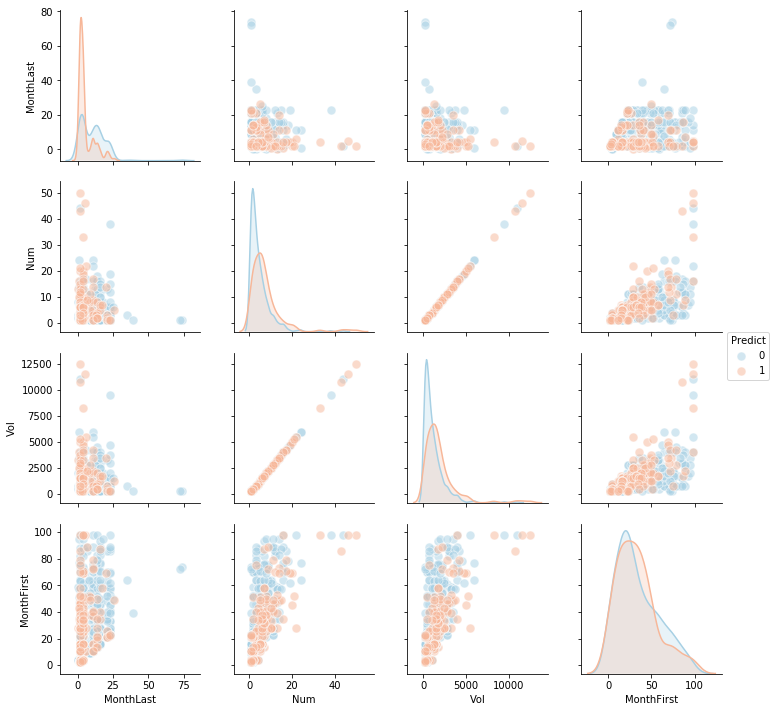

In [49]:
plt.close()
sns.pairplot(data, 
             vars=['MonthLast','Num','Vol','MonthFirst'],
             kind="scatter", 
             diag_kind="kde",
             hue="Predict", 
             plot_kws=dict(s=80, alpha=0.5),
             diag_kws=dict(shade=True),
             palette=sns.color_palette("RdBu_r", 2)
            )

Perfect correlation between `Number of donations` and `Total Volume Donated` can be explained only when the donated amount is always fixed. We can actualy calculate it: $12500/50 = 250 (c.c.)$.

In [54]:
X = data[['MonthLast','Num','MonthFirst']]
y = data['Predict']

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression()

cross_val_score(clf, X, y,
                scoring='neg_log_loss',
                cv=20
               )

array([-0.62423927, -0.54459666, -0.51414667, -0.51842387, -0.45995101,
       -0.46215052, -0.44932318, -0.4228894 , -0.46401826, -0.41053139,
       -0.44402339, -0.53336496, -0.60377637, -1.01676375, -0.47483104,
       -0.45336488, -0.40435105, -0.39542419, -0.42848889, -0.57011949])

# To do:
1. We have only 3 features so we can visualize them using `mayavi`.
2. SVM maybe a good choice.
3. Neural networks with Keras.
4. Feature engineering like Ratio.
3. Methods of validation.